In [32]:
from sdo.models.autocalibration_models import Autocalibration6#, Autocalibration16
import torch
import torch.nn as nn
import pandas as pd
from sdo.datasets.sdo_dataset import SDO_Dataset
from sdo.datasets.dimmed_sdo_dataset import DimmedSDO_Dataset
from sdo.pytorch_utilities import create_dataloader
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import (YEARLY, DateFormatter,
                              rrulewrapper, RRuleLocator, drange)
import matplotlib.dates as mdates
import sunpy.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

# import astropy.time
# from astropy.visualization import time_support
# import astropy.units as u
# from aiapy.calibrate import degradation
# from aiapy.calibrate.util import get_correction_table
import matplotlib as mpl
import datetime
import logging
logger = logging.getLogger()
logger.setLevel(logging.ERROR)
#logger.setLevel(logging.DEBUG)
#logging.debug("test")

ModuleNotFoundError: No module named 'sunpy'

In [3]:
channels = ['0094','0131','0171','0193','0211','0304','0335']
DATA_BASEDIR = '/fdl_sdo_data/SDOMLmm/fdl_sw/SDOMLmm'

In [4]:
apodize = True
prefix = 'luiz_exp_36_apodize'
# prefix = 'mark_experiment_euv_nothreshold_2011_2018_gunesh'
# prefix = 'mark_experiment_euv_nothreshold_2010_2016_3hr_gunesh'
#prefix = 'mark_experiment_euv_nothreshold_2010_2016_gunesh_b16'

kernel_size = 3
if apodize: prefix = prefix+'_apodize'
if kernel_size != 3: prefix = prefix+'_k{0:1d}'.format(kernel_size)
print(prefix)
epoch  = 400

prefix = 'luiz_exp_36_apodize'
#EXPERIMENT_RESULTS_AUTOCAL_mark_experiment_euv_nothreshold_2010_2016_gunesh_apodize_m16_0400_mark_experiment_euv_nothreshold_2010_2016_gunesh_apodize_m16_model.pth

modelfile = '/home/lguedesd/models/EXPERIMENT_RESULTS_AUTOCAL_luiz_exp_36_apodize_1000_luiz_exp_36_apodize_model.pth'
print(modelfile)
model = Autocalibration6(input_shape=[7, 256, 256], output_dim=7)#, kernel_size=kernel_size)
model.load_state_dict(torch.load(modelfile,map_location=torch.device('cpu')))
model.eval()
print(model)

modelfile = '/home/lguedesd/models/EXPERIMENT_RESULTS_AUTOCAL_luiz_exp_36_apodize_1000_luiz_exp_36_apodize_model.pth'
print(modelfile)
model_masked = Autocalibration6(input_shape=[7, 256, 256], output_dim=7)#, kernel_size=kernel_size)
model_masked.load_state_dict(torch.load(modelfile,map_location=torch.device('cpu')))
model_masked.eval()
print(model_masked)

train_dataset = SDO_Dataset(data_basedir=DATA_BASEDIR,
                                            data_inventory='/fdl_sdo_data/bucket/inventory.pkl',
                                            instr=['AIA','AIA','AIA','AIA','AIA','AIA','AIA'],
                                            channels=channels, yr_range=[2011,2019],
                                            mnt_step = 1,
                                            day_step = 5,
                                            h_step   = 1,
                                            min_step = 1,
                                            resolution=512,
                                            subsample =2,
                                            normalization=0, 
                                            scaling = True,
                                            shuffle = False,
                                            holdout = False,
                                            test_ratio = 0,
                                            test=False, apodize=apodize)

train_loader = create_dataloader(train_dataset, batch_size=4, num_dataloader_workers=1, train=False)

luiz_exp_36_apodize_apodize
/home/lguedesd/models/EXPERIMENT_RESULTS_AUTOCAL_luiz_exp_36_apodize_1000_luiz_exp_36_apodize_model.pth
Autocalibration6(
  (_conv2d1): Conv2d(7, 64, kernel_size=(3, 3), stride=(1, 1))
  (_conv2d1_maxpool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (_conv2d2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (_conv2d2_maxpool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (_fc): Linear(in_features=93312, out_features=7, bias=True)
)
/home/lguedesd/models/EXPERIMENT_RESULTS_AUTOCAL_luiz_exp_36_apodize_1000_luiz_exp_36_apodize_model.pth
Autocalibration6(
  (_conv2d1): Conv2d(7, 64, kernel_size=(3, 3), stride=(1, 1))
  (_conv2d1_maxpool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (_conv2d2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (_conv2d2_maxpool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (_fc): Linear(in_f

In [5]:
with torch.no_grad():
    for batch_idx, input_data in enumerate(train_loader):
        #output = model(input_data)
        #total_output = output
#         dates = np.array(files)
        print(batch_idx)
        break

0


In [6]:
print(kernel_size)
latent_input = nn.functional.conv2d(input_data, model.state_dict()['_conv2d1.weight'])
print(latent_input.std())
ones = torch.ones(latent_input[0,:,:,:].shape)
for c in range(ones.shape[0]):
    ones[c,:,:]*=model.state_dict()['_conv2d1.bias'][c]
for l in latent_input[:]:
    l += ones
print(latent_input.std())    
latent = nn.functional.max_pool2d(latent_input, kernel_size=kernel_size, stride=kernel_size)
latent[latent < 0.0] = 0.0
print(latent.std())
print(latent.shape)
latent2 = nn.functional.conv2d(latent, model.state_dict()['_conv2d2.weight'])
ones = torch.ones(latent2[0,:,:,:].shape)
for c in range(ones.shape[0]):
    ones[c,:,:]*=model.state_dict()['_conv2d2.bias'][c]
for l in latent2[:]:
    l += ones    
latent2 = nn.functional.max_pool2d(latent2, kernel_size=kernel_size, stride=kernel_size)
latent2[latent2 < 0.0] = 0.0
print(latent2.shape)

3
tensor(1.1973)
tensor(1.1857)
tensor(0.1221)
torch.Size([4, 64, 84, 84])
torch.Size([4, 128, 27, 27])


In [7]:
latent2.shape

torch.Size([4, 128, 27, 27])

In [8]:
def bytescale(img,vmin=0,vmax=255):
    return np.clip((img-vmin)/(vmax-vmin),0,1)

print(model.state_dict().keys())
w =  model.state_dict()['_conv2d1.weight'].numpy()
print(w.shape)

def visualize_images(img, dest=plt, figsize=None,vmin=0,vmax=1):
    nc = img.shape[0]
    if figsize ==None:
        figsize=(3*nc,3)
    fig = dest.figure(figsize=figsize)
    gs  = fig.add_gridspec(1,nc)
    for c in range(nc):
        this_panel = fig.add_subplot(gs[c])
        this_panel.imshow(img[c],vmin=vmin,vmax=vmax, cmap='gray')
        this_panel.set_title('{}'.format(channels[c]),fontsize=7)

def visualize_latent(latent,dest=plt,figsize=(10,10),vmin=0,vmax=1,cols=8,cmap='jet',label_color='white', showSum=False, fontsize=14):
    nc = latent.shape[0]
    fig = dest.figure(figsize=figsize)
    gs  = fig.add_gridspec(max([int(nc/cols),1]),cols)
    total=''
    for c in range(nc):
        this_panel = fig.add_subplot(gs[int(c/cols), c % cols])
        this_panel.imshow(latent[c].numpy(),vmin=vmin,vmax=vmax,cmap=cmap)
        this_panel.get_xaxis().set_visible(False)
        this_panel.get_yaxis().set_visible(False)
        this_panel.margins(0.0,0.0)
        if showSum:
            total = ': {0:.3f}'.format(latent[c].numpy().sum())
        this_panel.annotate('{}'.format(c)+total, (1.2,20.5),color=label_color, fontsize=fontsize)

def visualize_multi_kernels(w, channels=[2,3,5], dest=None, figsize=(10,10)):
    if dest == None:
        dest = plt
        fig = dest.figure(figsize=figsize)
        gs  = fig.add_gridspec(int(w.shape[0]/8),8)
    else:
        gs = dest.subplots(int(w.shape[0]/8),8)
        fig = dest
        
    for i in range(w.shape[0]):
        this_panel = fig.add_subplot(gs[int(i/8), i  % 8])
        #b = ax[int(i/8), i  % 8]
        this_panel.imshow(bytescale(np.transpose(w[i, channels, :,:],(1,2,0)), vmin=-0.25, vmax=0.25))
        this_panel.annotate('{}'.format(i),(0.2,1.5),color='white',fontsize=14)
        this_panel.get_xaxis().set_visible(False)
        this_panel.get_yaxis().set_visible(False)
        this_panel.margins(0.0,0.0)
        

odict_keys(['_conv2d1.weight', '_conv2d1.bias', '_conv2d2.weight', '_conv2d2.bias', '_fc.weight', '_fc.bias'])
(64, 7, 3, 3)


(64, 7, 3, 3) torch.Size([4, 64, 84, 84])


<Figure size 1224x1080 with 0 Axes>

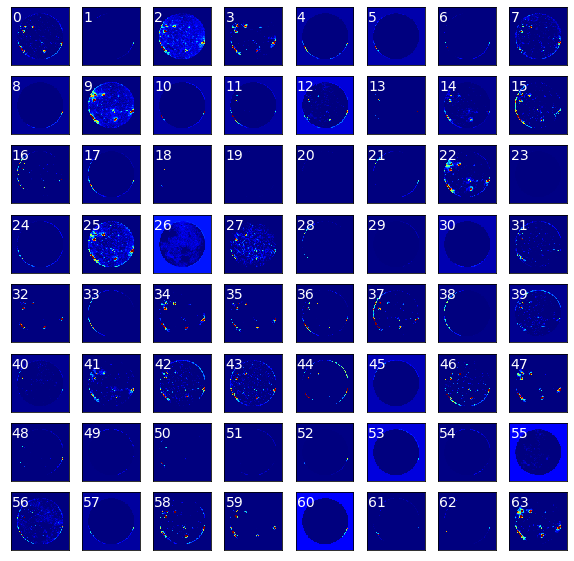

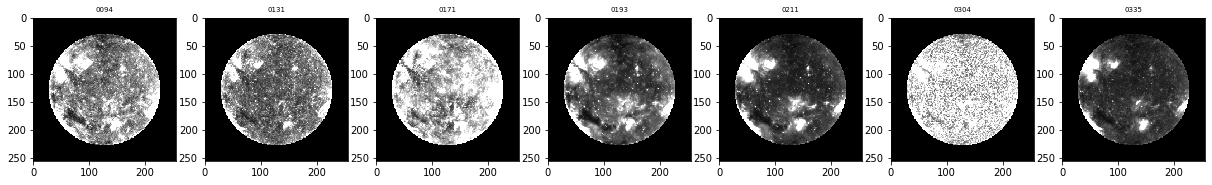

In [7]:
row=3
#fig, ax = plt.subplots(1,2)
fig = plt.figure(figsize=(17,15))
gs  = fig.add_gridspec(1,2)
print(w.shape, latent.shape)

#visualize_multi_kernels(w, channels = [0,3,4]) #, dest=fig.add_subplot(gs[0,0]))
#plt.show()
visualize_latent(latent[row])
plt.show()
visualize_images(input_data[row],vmin=0,vmax=0.4)
plt.savefig('sample_images.jpg')

In [ ]:
#visualize_multi_kernels(model.state_dict()['_conv2d2.weight'], channels = [0,3,4], figsize=(20,20)) #, dest=fig.add_subplot(gs[0,0]))
#plt.show()
#visualize_latent(latent2[row],figsize=(30,30))
#plt.show()

In [ ]:
fc = model.state_dict()['_fc.weight']
print(fc.shape)
fc = fc.reshape(1,latent2.shape[1],latent2.shape[2],latent2.shape[3])
print(fc.shape)

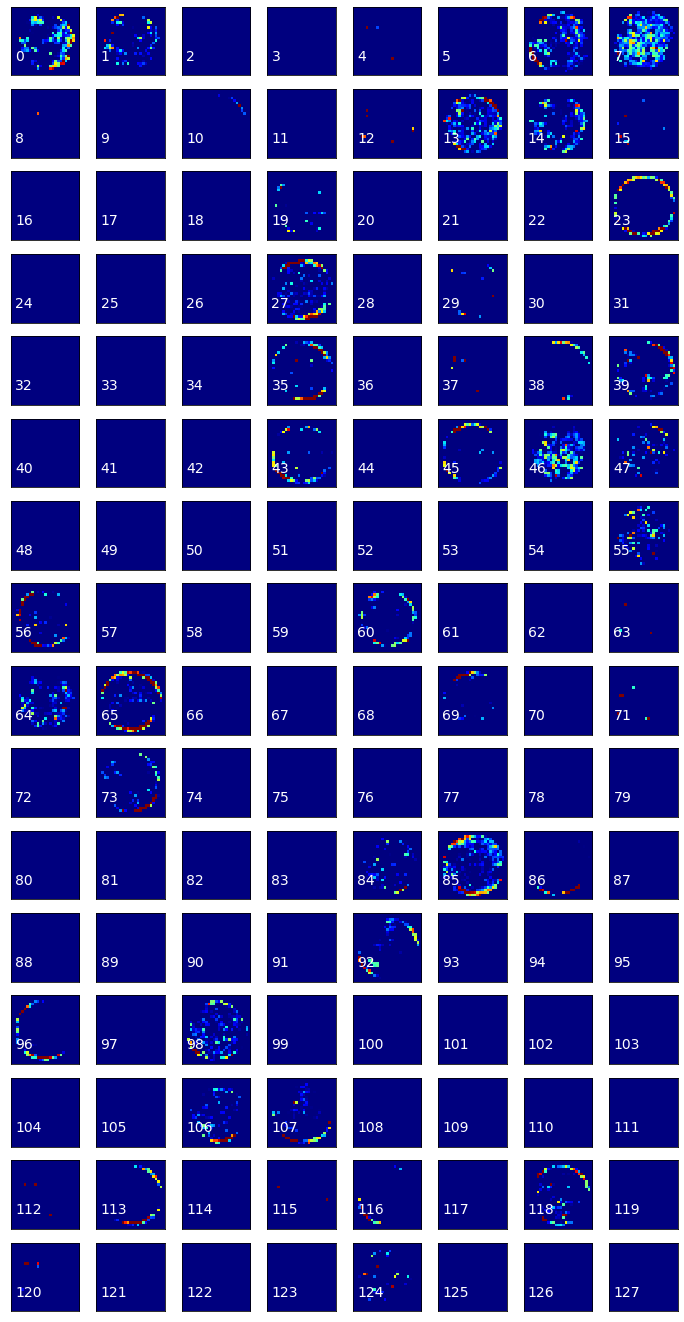

In [15]:
visualize_latent(latent2[row],figsize=(12,24),vmin=0,vmax=0.1,cmap='jet')
plt.savefig('latent2_temp.jpg')

In [ ]:
#visualize_latent(fc[:,67],figsize=(10,20))
activation = []
for i in range(fc.shape[1]):
    activation.append(torch.abs(fc[:,i,:,:]).mean().numpy())

In [ ]:
fc.shape

In [ ]:
arg_activation = np.argsort(np.array(activation))
arg_activation[-1]

In [ ]:
visualize_latent(fc[:,arg_activation[-1]],figsize=(10,20))
visualize_latent(fc[:,arg_activation[-2]],figsize=(10,20))
visualize_latent(fc[:,arg_activation[-3]],figsize=(10,20))
visualize_latent(fc[:,25],figsize=(10,20))


In [ ]:
latent2[row].shape, fc[0].shape


In [ ]:
visualize_latent(latent2[row],figsize=(10,20),cols=8, vmin=0.0,vmax=0.1)

In [ ]:
for i in range(fc.shape[0]):
    #visualize_latent(fc[i]*latent2[row],figsize=(10,20),cols=8,
    #                 vmin=-0.002,vmax=0.002,cmap='gray',label_color='yellow',showSum=True, fontsize=10)
    #plt.savefig(prefix+'_fcdotlatent2_ch{0:1d}.jpg'.format(i))
    inner = fc[i]*latent2[row]
    print(inner.shape)
    res = (fc[i]*latent2[row]).sum(axis=(1,2))
    index = (torch.argsort(torch.abs(res)))
    select = inner[[index[-1],index[-2],index[-3],index[-4]],:,:]
    visualize_latent(select,figsize=(3,12),cols=4,
                     vmin=-0.002,vmax=0.002,cmap='gray',label_color='yellow',showSum=True, fontsize=10)

In [ ]:
def norm(v):
    return np.sqrt((v*v).sum())
def kernel_dot(w):
    N = w.shape[0]
    M = np.zeros(shape=(N,N), dtype=np.float)
    for i in range(N):
        for j in range(N):
            M[i,j] = (w[i,:,:]*w[j,:,:]).sum()/(norm(w[i,:,:])*norm(w[j,:,:]))
    return M

In [ ]:
np.rank(w[:,0,:,:].reshape(w.shape[0],w.shape[2]*w.shape[3]))

In [ ]:
latent2.shape

In [ ]:
input_data.shape

In [ ]:
model

In [ ]:
plt.imshow(input_data[row,0,:,:].numpy(),vmax=0.9)

In [ ]:
def visualize(img,latent):
    nc = img.shape[0]
    fig, ax=plt.subplots(1,nc,figsize=(10*nc,10))
    for c in range(nc):
        ax[c].imshow(img[c],vmin=0,vmax=1, cmap='gray')
        ax[c].set_title('{}'.format(channels[c]),fontsize=30)
    plt.show()
    nc = latent.shape[0]
    fig, ax=plt.subplots(int(nc/8),8, figsize=(10,10))
    for c in range(nc):
        ax[int(c/8), c%8].imshow(latent[c],vmin=0,vmax=2,cmap='jet')
        ax[int(c/8), c%8].get_xaxis().set_visible(False)
        ax[int(c/8), c%8].get_yaxis().set_visible(False)
        ax[int(c/8), c%8].margins(0.0,0.0)
        ax[int(c/8), c%8].set_title('{}'.format(c))
    plt.show()

In [ ]:
def panel(x):
    shape = x.shape
    img = np.zeros(shape=(shape[0]*shape[2],shape[1]*shape[3]), dtype=np.float)
    for i in range(shape[0]):
        for j in range(shape[1]):
            img[i*shape[2]:(i+1)*shape[2], j*shape[3]:(j+1)*shape[3]] = x[i,j,:,:]
    return img

In [ ]:
plt.imshow(latent[12,7,:,:].numpy(), interpolation='nearest', cmap='jet')
plt.colorbar()

In [ ]:
model.state_dict()['_conv2d1.weight'].shape

In [ ]:
model.state_dict()['_conv2d2.weight'].shape

In [ ]:
input_data.shape

In [ ]:
np.b

In [ ]:
visualize_latent_one(latent2[row],figsize=(12,24),vmin=0,vmax=0.1,cmap='copper')
plt.savefig('latent2.jpg')

In [9]:
def visualize_latent_one(latent,dest=plt,figsize=(10,10),vmin=0,vmax=1,cols=8,cmap='jet',label_color='white', showSum=False, fontsize=14):
    nc = latent.shape[0]
    fig = dest.figure(figsize=figsize)
    gs  = fig.add_gridspec(max([int(nc/cols),1]),cols)
    total=''
    this_panel = fig.add_subplot(gs[int(79/cols), 79 % cols])
    this_panel.imshow(latent[79].numpy(),vmin=vmin,vmax=vmax,cmap=cmap)
    this_panel.get_xaxis().set_visible(False)
    this_panel.get_yaxis().set_visible(False)
    this_panel.margins(0.0,0.0)
    if showSum:
        total = ': {0:.3f}'.format(latent[c].numpy().sum())
    this_panel.annotate('{}'.format(79)+total, (1.2,20.5),color=label_color, fontsize=fontsize)


In [11]:
latent.shape

torch.Size([4, 64, 84, 84])

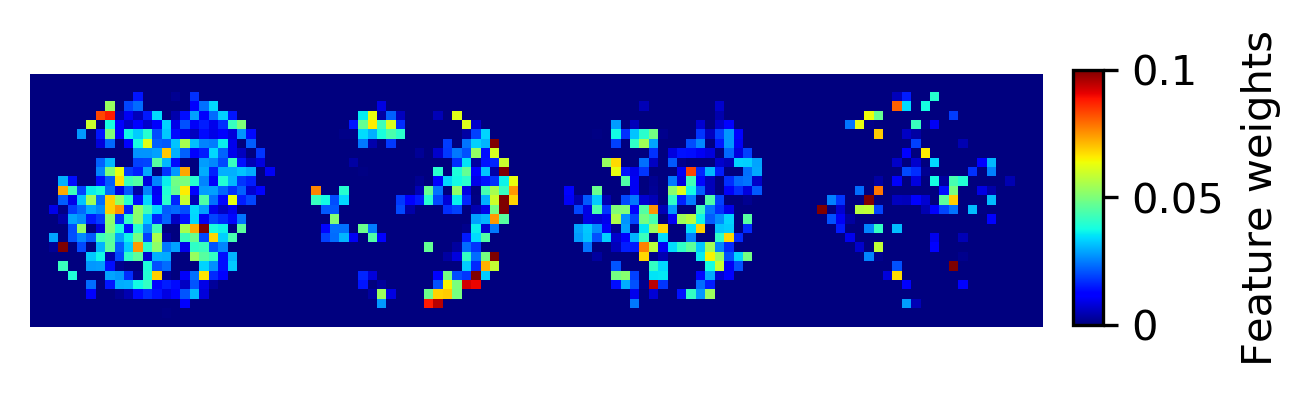

In [36]:
row=3
latent_temp = latent2[row,:,:,:]

fig,ax = plt.subplots(nrows=1, ncols=4, figsize=(5,5),dpi=300)
fig.subplots_adjust(hspace=0, wspace=0)
ax.ravel()

ax[0].imshow(latent_temp[7,].numpy(),vmin=0,vmax=0.1,cmap='jet')
ax[0].axis('off')
ax[1].imshow(latent_temp[0,].numpy(),vmin=0,vmax=0.1,cmap='jet')
ax[1].axis('off')
ax[2].imshow(latent_temp[46,].numpy(),vmin=0,vmax=0.1,cmap='jet')
ax[2].axis('off')
ax[3].imshow(latent_temp[55,].numpy(),vmin=0,vmax=0.1,cmap='jet')
ax[3].axis('off')

# ax[1,0].imshow(latent_193_temp[23,].numpy(),vmin=0,vmax=0.1,cmap='copper')
# ax[1,0].set_xticks([])
# ax[1,0].set_yticks([])
# ax[1,0].set_ylabel('Single-Channel $193~\AA$')
# ax[1,1].imshow(latent_193_temp[38,].numpy(),vmin=0,vmax=0.1,cmap='copper')
# ax[1,1].axis('off')
# ax[1,2].imshow(latent_193_temp[39,].numpy(),vmin=0,vmax=0.1,cmap='copper')
# ax[1,2].axis('off')
# ax[1,3].imshow(latent_193_temp[79,].numpy(),vmin=0,vmax=0.1,cmap='copper')
# ax[1,3].axis('off')

# ax[2,0].imshow(latent_304_temp[23,].numpy(),vmin=0,vmax=0.1,cmap='copper')
# ax[2,0].set_xticks([])
# ax[2,0].set_yticks([])
# ax[2,0].set_ylabel('Single-Channel $304~\AA$')
# ax[2,1].imshow(latent_304_temp[52,].numpy(),vmin=0,vmax=0.1,cmap='copper')
# ax[2,1].axis('off')
# ax[2,2].imshow(latent_304_temp[79,].numpy(),vmin=0,vmax=0.1,cmap='copper')
# ax[2,2].axis('off')
# ax[2,3].imshow(latent_304_temp[90,].numpy(),vmin=0,vmax=0.1,cmap='copper')
# ax[2,3].axis('off')

cmap = mpl.cm.jet
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.42, 0.02, 0.17])#[left, bottom, width, height]
norm = mpl.colors.Normalize(vmin=0, vmax=0.1)
cb1 = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap,norm=norm)
cb1.set_ticks([0,0.05, 0.1])
cb1.set_ticklabels(["0", "0.05","0.1"])
cb1.set_label('Feature weights',fontsize=10)
# cbar_ax.ax.set_ylabel('Intensity [DN/s/pixel]', rotation=90, labelpad=15)

plt.savefig('latent.pdf',bbox_inches='tight',dpi=1000)

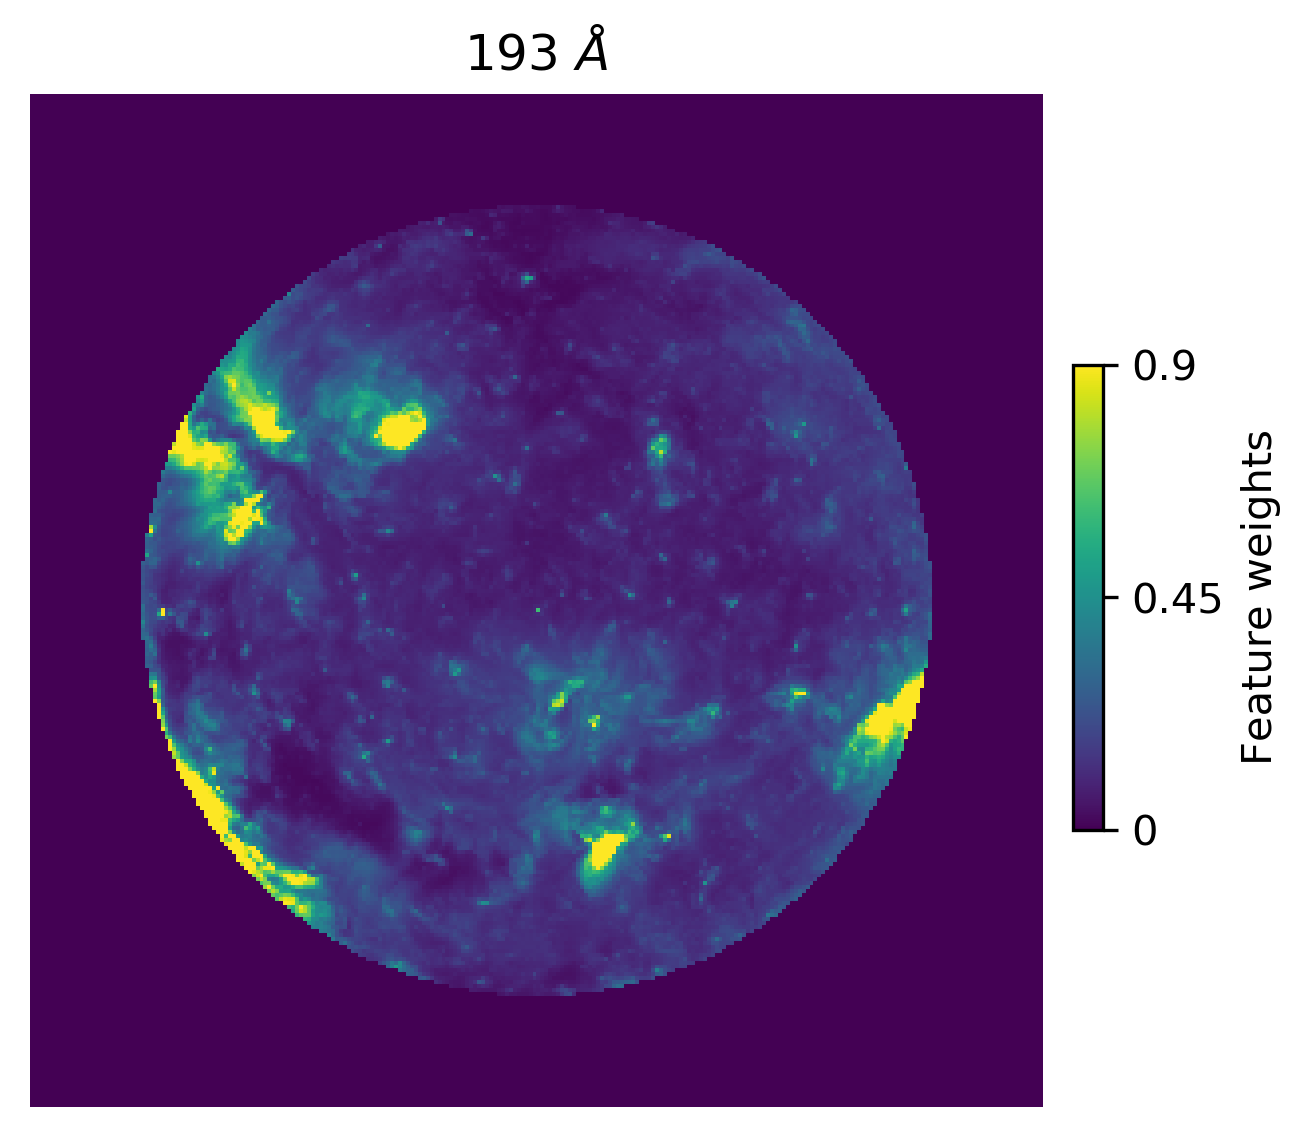

In [31]:
fig,ax = plt.subplots(figsize=(5,5),dpi=300)
fig.subplots_adjust(hspace=0, wspace=0.02)
ax.imshow(input_data[0,3,:,:].numpy(),vmax=1)
ax.axis('off')
ax.set_title('$193~\AA~$')

cmap = mpl.cm.viridis
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.35, 0.02, 0.31])#[left, bottom, width, height]
norm = mpl.colors.Normalize(vmin=0, vmax=0.9)
cb1 = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap,norm=norm)
cb1.set_ticks([0,0.45, 0.9])
cb1.set_ticklabels(["0", "0.45","0.9"])
cb1.set_label('Feature weights')

plt.savefig('reference.pdf',bbox_inches='tight',dpi=1000)

In [184]:
channels = ['0193']#,'0131','0171','0193','0211','0304','0335']
apodize = True
prefix = 'luiz_exp_36_single_apodize'
# prefix = 'mark_experiment_euv_nothreshold_2011_2018_gunesh'
# prefix = 'mark_experiment_euv_nothreshold_2010_2016_3hr_gunesh'
#prefix = 'mark_experiment_euv_nothreshold_2010_2016_gunesh_b16'

kernel_size = 3
if apodize: prefix = prefix+'_apodize'
if kernel_size != 3: prefix = prefix+'_k{0:1d}'.format(kernel_size)
print(prefix)
epoch  = 400

prefix = 'luiz_exp_36_apodize'
#EXPERIMENT_RESULTS_AUTOCAL_mark_experiment_euv_nothreshold_2010_2016_gunesh_apodize_m16_0400_mark_experiment_euv_nothreshold_2010_2016_gunesh_apodize_m16_model.pth

modelfile = '/home/lguedesd/models/EXPERIMENT_RESULTS_AUTOCAL_luiz_exp_33_0193_masked_1000_luiz_exp_33_0193_masked_model.pth'
print(modelfile)
model = Autocalibration6(input_shape=[1, 256, 256], output_dim=1)#, kernel_size=kernel_size)
model.load_state_dict(torch.load(modelfile,map_location=torch.device('cpu')))
model.eval()
print(model)

train_dataset = SDO_Dataset(data_basedir=DATA_BASEDIR,
                                            data_inventory='/fdl_sdo_data/bucket/inventory.pkl',
                                            instr=['AIA','AIA','AIA','AIA','AIA','AIA','AIA'],
                                            channels=channels, yr_range=[2011,2019],
                                            mnt_step = 1,
                                            day_step = 5,
                                            h_step   = 1,
                                            min_step = 1,
                                            resolution=512,
                                            subsample =2,
                                            normalization=0, 
                                            scaling = True,
                                            shuffle = False,
                                            holdout = False,
                                            test_ratio = 0,
                                            test=False, apodize=apodize)

train_loader = create_dataloader(train_dataset, batch_size=4, num_dataloader_workers=1, train=False)

with torch.no_grad():
    for batch_idx, input_data in enumerate(train_loader):
        #output = model(input_data)
        #total_output = output
#         dates = np.array(files)
        print(batch_idx)
        break
        
print(kernel_size)
latent_single_input = nn.functional.conv2d(input_data, model.state_dict()['_conv2d1.weight'])
print(latent_single_input.std())
ones = torch.ones(latent_single_input[0,:,:,:].shape)
for c in range(ones.shape[0]):
    ones[c,:,:]*=model.state_dict()['_conv2d1.bias'][c]
for l in latent_single_input[:]:
    l += ones
print(latent_single_input.std())    
latent_single = nn.functional.max_pool2d(latent_single_input, kernel_size=kernel_size, stride=kernel_size)
latent_single[latent_single < 0.0] = 0.0
print(latent_single.std())
print(latent_single.shape)
latent2_single = nn.functional.conv2d(latent_single, model.state_dict()['_conv2d2.weight'])
ones = torch.ones(latent2_single[0,:,:,:].shape)
for c in range(ones.shape[0]):
    ones[c,:,:]*=model.state_dict()['_conv2d2.bias'][c]
for l in latent2_single[:]:
    l += ones    
latent2_single = nn.functional.max_pool2d(latent2_single, kernel_size=kernel_size, stride=kernel_size)
latent2_single[latent2_single < 0.0] = 0.0
print(latent2_single.shape)

luiz_exp_36_single_apodize_apodize
/home/lguedesd/models/EXPERIMENT_RESULTS_AUTOCAL_luiz_exp_33_0193_masked_1000_luiz_exp_33_0193_masked_model.pth
Autocalibration6(
  (_conv2d1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (_conv2d1_maxpool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (_conv2d2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (_conv2d2_maxpool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (_fc): Linear(in_features=93312, out_features=1, bias=True)
)
0
3
tensor(0.3621)
tensor(0.4157)
tensor(0.0490)
torch.Size([4, 64, 84, 84])
torch.Size([4, 128, 27, 27])


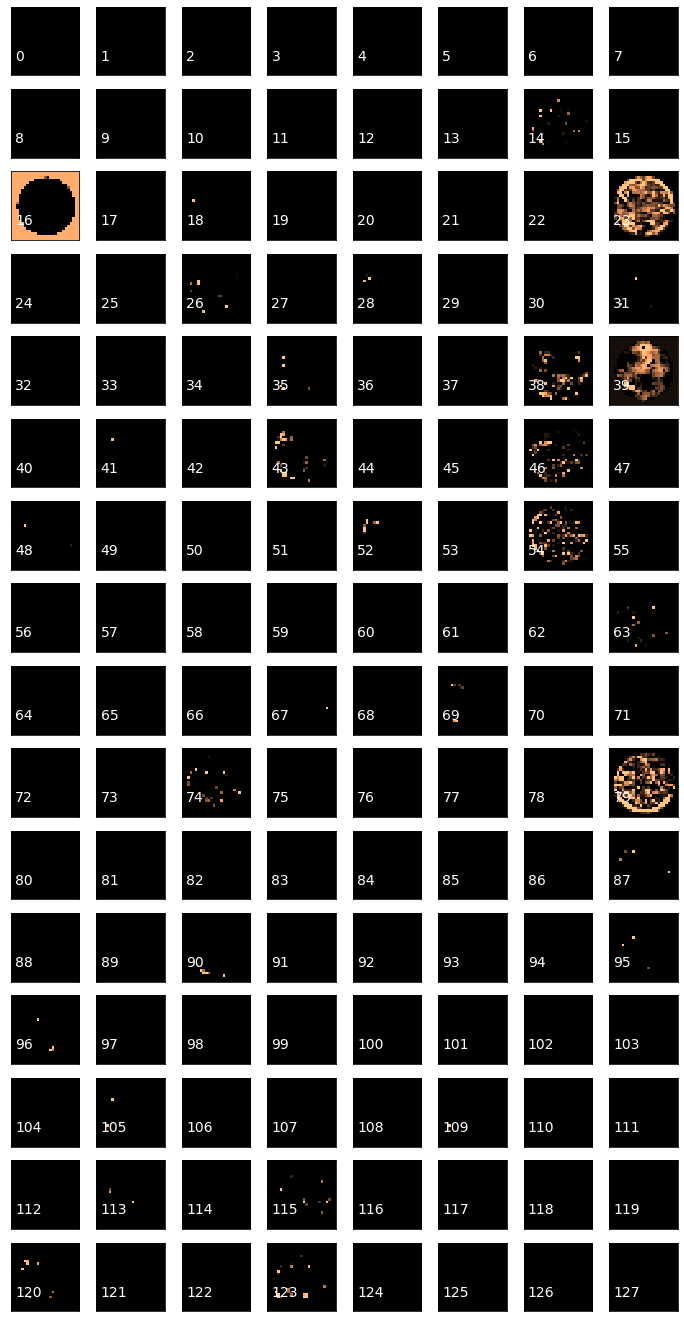

In [122]:
visualize_latent(lantent_193[3,],figsize=(12,24),vmin=0,vmax=0.1,cmap='copper')
# plt.savefig('latent2_temp.jpg')

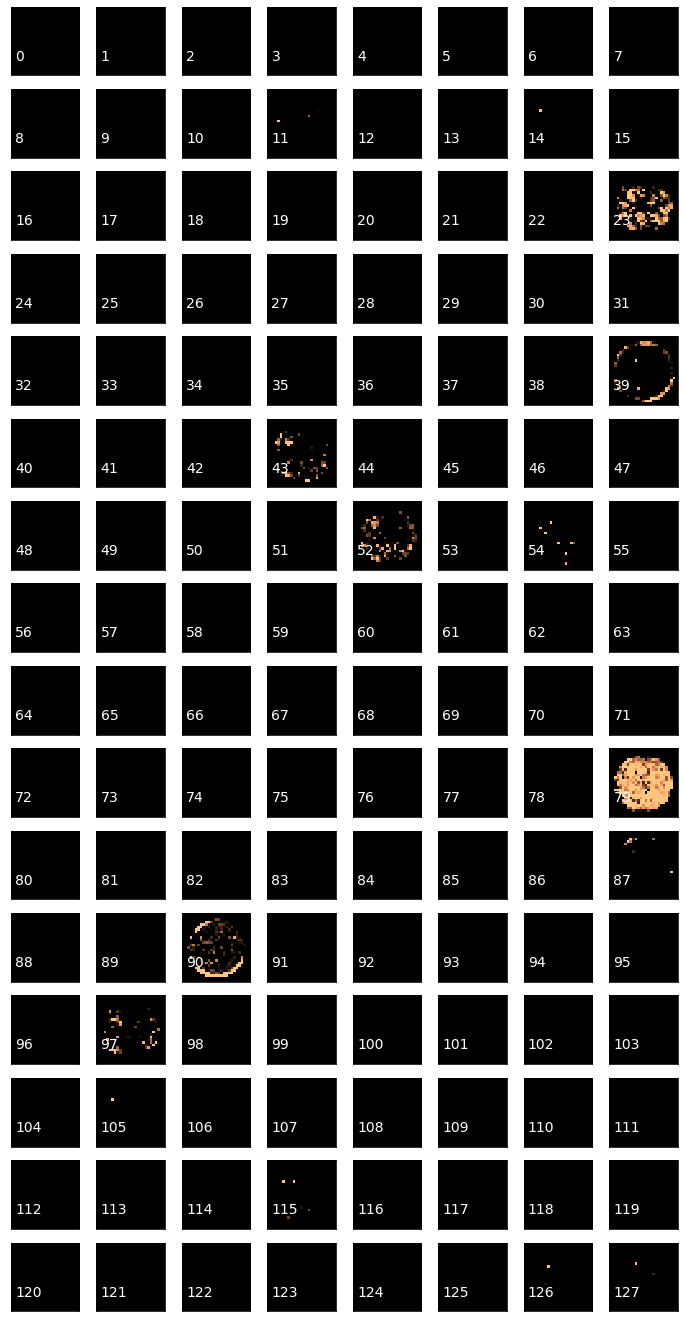

In [123]:
visualize_latent(lantent_304[3,],figsize=(12,24),vmin=0,vmax=0.1,cmap='copper')

In [115]:
lantent_193 = latent2_single

In [119]:
lantent_304 = latent2_single

In [129]:
np.save('lantent_193.pkl',lantent_193.numpy())
np.save('lantent_304.pkl',lantent_304.numpy())

In [176]:
input_data[row,0,:,:]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [183]:
input_304 = input_data
np.save('input_304.pkl',input_304.numpy())

In [185]:
input_193 = input_data
np.save('input_193.pkl',input_193.numpy())

In [29]:
input_data.size()

torch.Size([4, 7, 256, 256])

In [35]:
np.save('input.pkl', input_data.numpy())